经验总结：
1. 此模型适合牛市，大部分正样本都在牛市，所以训练出来的模型在熊市中效果并不好，但是实验表明，用14年以前的数据train的model能够适应15年的牛市数据
2. 模型可以用来大概预测牛市初期，因为在熊市中predict=1的数量非常少


In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.datasets import  make_classification


/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df_raw = pd.read_csv("./month_reverse_3683_2018-12-21.tsv", sep="\t")
# df_raw = pd.read_csv("~/buypoints.tsv", sep="\t")


features = ["average_inner_amplitude", 
            "average_outer_amplitude", 
            "average_turn_rate", 
            "increase_before_fallback", 
            "max_increase",  
            "pb_height", 
            "pe_height", 
            "profit_growth", 
            "sma10_120", 
            "sma10_250", 
            "sma120_250", 
            "sma50_120", 
            "variance", 
            "volume_ratio",
            "business_growth",
            "pe",
            "pb",
            "mkt_cap",
            "new_high_days",
#             "days_with_lower_price",
            "days_from_bottom",
            "roe",
            "eps",
            "close_sma50",
            "close_sma250",
            "eps_growth",
            "rps50",
            "rps120",
            "rps250"
           ]
target = ["target"]

# Add filter here
# 1. only use end_date <= one year before

now = datetime.now()
end = now - timedelta(days=250)

df_raw = df_raw[df_raw["start_date"] < end.strftime("%Y-%m-%d")]



测试，按日期划分数据，看是旧数据train的model是否可以预测未来的数据

excluded = now - timedelta(days=250*6.5)
cut_point =  excluded.strftime("%Y-%m-%d")
print(cut_point)
df_new = df_raw[df_raw["end_date"] >= cut_point]
df_old = df_raw[df_raw["end_date"] < cut_point ]

X = df_new[features]
y = df_new[target]

X_train = df_new[features]
y_train = df_new[target]
X_test = df_old[features]
y_test = df_old[target]

In [3]:
X = df_raw[features]
y = df_raw[target].values.ravel()

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state = 88)


print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Train set shape: (8717, 28)
Test set shape: (2180, 28)


In [4]:
# try classification

from lightgbm import LGBMClassifier,LGBMModel
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, confusion_matrix, average_precision_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
import sklearn


In [5]:
#default initial parameters for feature selection
lgb_model = LGBMClassifier(boosting_type='gbdt',
                      objective='binary',
                      max_depth=7,
                      learning_rate=0.1,
                      n_estimators=150,
                      min_child_samples=15,
                     silent=False)

# Initialize CV and evaluation objects
kfold = KFold(n_splits=4)

feature_selector = RFECV(lgb_model, cv=kfold, verbose=1, scoring='average_precision')
feature_selector.fit(X_train, y_train)


Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 28 features.


RFECV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
   estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=7,
        min_child_samples=15, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=150, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
   n_jobs=1, scoring='average_precision', step=1, verbose=1)

In [6]:
# Mask with selected features
selected_feature_mask = feature_selector.get_support(indices=True)
selected_features = X_train[features].iloc[:, selected_feature_mask].columns.values
deleted_features = list(set(features) - set(selected_features))

print("Selected features: \n{}\n".format(selected_features))
print("Deleted features: \n{}\n".format(deleted_features))


# Now we can drop the features deemed bad by the model
X_train_filtered = X_train.drop(deleted_features, axis=1)
X_test_filtered = X_test.drop(deleted_features, axis=1)
X_filtered = X.drop(deleted_features, axis=1)

Selected features: 
['average_outer_amplitude' 'average_turn_rate' 'max_increase' 'pb_height'
 'profit_growth' 'sma10_120' 'sma120_250' 'sma50_120' 'variance'
 'volume_ratio' 'business_growth' 'pe' 'pb' 'mkt_cap' 'new_high_days' 'roe'
 'close_sma50' 'close_sma250' 'rps50' 'rps120' 'rps250']

Deleted features: 
['eps', 'increase_before_fallback', 'sma10_250', 'eps_growth', 'days_from_bottom', 'average_inner_amplitude', 'pe_height']



过拟合的解决方案有：
1. 减小learning rate
2. feature selection,减少feature
3. 减少树的数量
4. 控制min data in leaf
5. 添加正则项

In [7]:
from sklearn.model_selection import GroupKFold, GridSearchCV

param_grid = {'max_depth': [5, 6, 7], 
              'learning_rate': [0.01, 0.05, 0.1],
              'n_estimators': [50, 100, 150],
              'min_data_in_leaf':  [10, 15, 20, 31],
             }
 
kfold = KFold(n_splits=4)

gs = GridSearchCV(lgb_model, param_grid, scoring='average_precision', cv=kfold, refit=True)

gs.fit(X_train_filtered, y_train, verbose=100)
final_model = gs.best_estimator_

final_model._Booster.save_model("month_reverse_gbdt_model.txt")


print(y_train.shape)
print("Best parameters: ", gs.best_params_)



(8717,)
Best parameters:  {'learning_rate': 0.05, 'max_depth': 6, 'min_data_in_leaf': 31, 'n_estimators': 150}


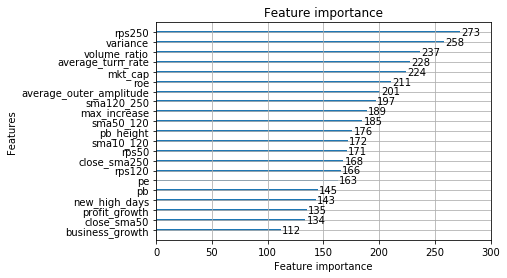

In [8]:
import lightgbm
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 16))
ax = lightgbm.plot_importance(final_model)

plt.show()

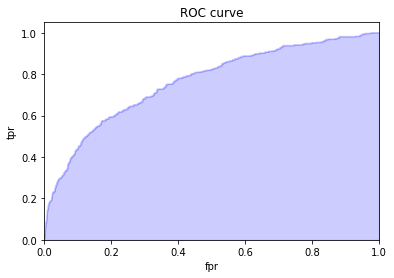

AUC =  0.763591487365


In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

for mod, X_t, y_t in [(final_model, X_test_filtered, y_test)]:
    preds = mod.predict_proba(X_t)
    fpr, tpr, thresholds = roc_curve(y_t, preds[:,1], pos_label=1)
    
    plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
    plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')

    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('ROC curve')
    plt.show()

    auc = roc_auc_score(y_t, preds[:, 1])
    print("AUC = ", auc)

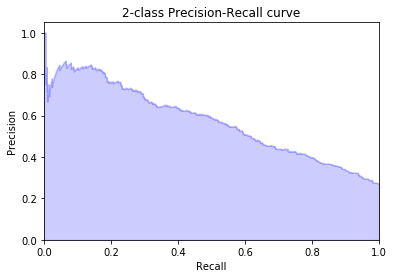

r=0.4905 p=0.60 f1=0.54 threshold=0.3803
r=0.4527 p=0.61 f1=0.52 threshold=0.4032
r=0.4355 p=0.62 f1=0.51 threshold=0.4127
r=0.4079 p=0.63 f1=0.50 threshold=0.4325
r=0.3941 p=0.64 f1=0.49 threshold=0.4484
r=0.3632 p=0.65 f1=0.47 threshold=0.4692
r=0.3236 p=0.66 f1=0.43 threshold=0.4908
r=0.3098 p=0.67 f1=0.42 threshold=0.5015
r=0.3029 p=0.68 f1=0.42 threshold=0.5048
r=0.2978 p=0.69 f1=0.42 threshold=0.5076
r=0.2960 p=0.70 f1=0.42 threshold=0.5153
r=0.2892 p=0.71 f1=0.41 threshold=0.5193
r=0.2788 p=0.72 f1=0.40 threshold=0.5309
r=0.2599 p=0.73 f1=0.38 threshold=0.5441
r=0.2324 p=0.74 f1=0.35 threshold=0.5630
r=0.2289 p=0.75 f1=0.35 threshold=0.5719
r=0.2289 p=0.76 f1=0.35 threshold=0.5719
r=0.1876 p=0.77 f1=0.30 threshold=0.5939
r=0.1876 p=0.78 f1=0.30 threshold=0.5939
r=0.1824 p=0.79 f1=0.30 threshold=0.6009
r=0.1824 p=0.80 f1=0.30 threshold=0.6009
r=0.1773 p=0.81 f1=0.29 threshold=0.6040
r=0.1687 p=0.82 f1=0.28 threshold=0.6095
r=0.1532 p=0.83 f1=0.26 threshold=0.6327
r=0.1411 p=0.84 

In [10]:

import math
def max_recall_for_precision(data, scores, pos_label, min_pr):
#       """Find precision, recall, threshold which is >= min_pr and maximizes recall"""
    if pos_label==0:
        pr, rec, thresh = precision_recall_curve(1 - data, 1 - scores, pos_label=1)
        thresh = 1 - thresh #convert threshold back to P(nondefect) score space
    else:
        pr, rec, thresh = precision_recall_curve(data, scores, pos_label=1)
    values = [(r, p, t) for p, r, t in zip(pr, rec, thresh) if p >= min_pr]
    if len(values) >=1:
        r, p, t = max(values)
        return p, r, t
    return None, None, None


def plot_prcurve(y_test, y_pred):
    plt.figure(figsize=(6, 4))
    precision,recall,threshold = precision_recall_curve(y_test, y_pred)
    plt.step(recall, precision, color='b', alpha=0.1, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')
    plt.show()

for mod,X_t in [(final_model, X_test_filtered)]:
    preds = mod.predict_proba(X_t)
    plot_prcurve(y_test, preds[:,1])

    for min_pr in range(60, 90, 1):
        min_pr = min_pr / 100.0
        p,r,t = max_recall_for_precision(y_test, preds[:,1], 1, min_pr)
        f1 = 2 * min_pr * r / (min_pr + r)
        print("r=%.4f p=%.2f f1=%.2f threshold=%.4f" % (r, min_pr, f1, t))

    for score in ['average_precision']:
        evaluator = sklearn.metrics.get_scorer(score)
        score_val = evaluator(mod, X_t, y_test)
        print(score, score_val)

(8717, 21)
(8717,)


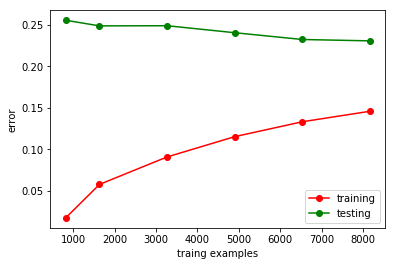

In [11]:
from sklearn.model_selection import learning_curve
print(X_train_filtered.shape)
print(y_train.shape)

train_sizes,train_score,test_score = learning_curve(
    final_model,
    X_filtered.values,
    y,
    train_sizes=[0.1,0.2,0.4,0.6,0.8,1],
    cv=4,
    scoring='accuracy')

train_error =  1- np.mean(train_score,axis=1)
test_error = 1- np.mean(test_score,axis=1)
plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training')
plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('traing examples')
plt.ylabel('error')
plt.show()

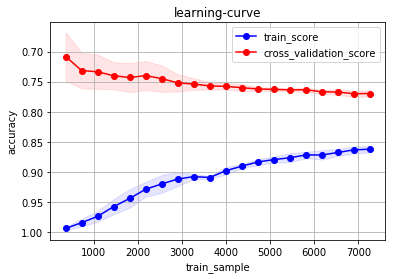

midpoint 0.815719610631 diff 0.102925070987


(0.81571961063145004, 0.10292507098716652)

In [12]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=None, n_jobs=1, title = "learning-curve", train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose, scoring='accuracy')
 
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
 
    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"train_sample")
        plt.ylabel(u"accuracy")
        plt.gca().invert_yaxis()
        plt.grid()
 
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"train_score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"cross_validation_score")
 
        plt.legend(loc="best")
 
        plt.draw()
        plt.show()
        plt.gca().invert_yaxis()
 
    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    print("midpoint", midpoint, "diff", diff)
    return midpoint, diff

plot_learning_curve(
    final_model,
    X_filtered.values,
    y
)